In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import torch.optim as optim
import torch.autograd as autograd

from mog_eigval_dist import *
from model import *
from utils import *

/home/naren/venv/torchml/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


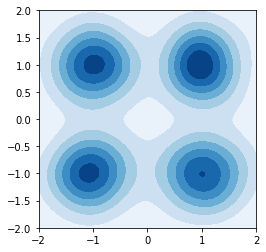

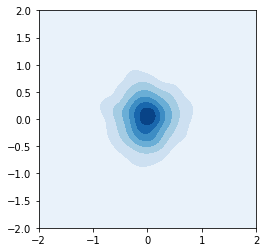

In [2]:
# 2-D dist
# target dist -- normal ([-1, 1], 0.4)
# aux dist -- normal ([1, -1], 0.4)
# input dist -- normal (0, 1)
batch_size = 512
inputs = np.random.normal(loc=[0,0], scale=[0.4,0.4], size=[batch_size, 2])
train1 = np.random.normal(loc=[-1,1], scale=[0.4,0.4], size=[batch_size, 2])
train2 = np.random.normal(loc=[1,-1], scale=[0.4,0.4], size=[batch_size, 2])
aux1 = np.random.normal(loc=[-1,-1], scale=[0.4,0.4], size=[batch_size, 2])
aux2 = np.random.normal(loc=[1,1], scale=[0.4,0.4], size=[batch_size, 2])

out = np.vstack([train1, train2, aux1, aux2])
kde(out[:,0], out[:,1])
kde(inputs[:,0], inputs[:,1])

In [12]:
#tgt_classifier = MLP_Discriminator(depth=4, width=16, activation=SELU,insize=2,outsize=2).cuda()
#for fc in get_modules_of_type(module_type=nn.Linear, net=tgt_classifier):
#    selu_init(fc)
#tc_optim = optim.Adam(tgt_classifier.parameters())

def sample_dist(tmu, tsig, batch_size=512):
    t = np.random.normal(loc=t1mu, scale=t1sig, size=[batch_size//2, 2])
    return t
def get_label(n, l, size=1):
    # return one-hot encoding of length l with nth element 1
    return torch.FloatTensor(np.identity(n=l)[n,:].reshape(1,2)).expand(size, -1).contiguous()
def train_classifier(net, opt, loss_fn, tmus, tsigs, model_name, iterations=4000):
    assert(len(tmus) == len(tsigs))
    ndist = len(tmus)
    for iteration in range(iterations):
        opt.zero_grad()
        dists = [sample_dist(tmus[i], tsigs[i]) for i in range(ndist)]
        
#np.vstack([[0,1]]*512)      


In [16]:
get_label(0, 2)

tensor([[1., 0.]])

In [8]:
G = MLP_Generator(depth=4, width=16, activation=SELU,bs=512,insize=2,outsize=2).cuda()
D = MLP_Discriminator(depth=4, width=16, activation=SELU,insize=2,outsize=1).cuda()

for fc in get_modules_of_type(module_type=nn.Linear, net=G):
    selu_init(fc)
for fc in get_modules_of_type(module_type=nn.Linear, net=D):
    selu_init(fc)

#g_optim = optim.RMSprop(G.parameters(), alpha=5e-4)
#d_optim = optim.RMSprop(D.parameters(), alpha=5e-4)
g_optim = optim.Adam(G.parameters())
d_optim = optim.Adam(D.parameters())

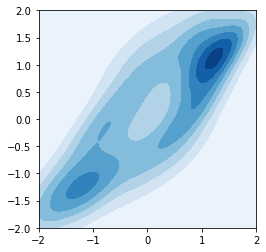

In [9]:
out = G(torch.FloatTensor(inputs).cuda()).detach().cpu().numpy()
kde(out[:,0], out[:,1], save_file='./expt_results/WMLPG_gp_init1.png')

In [5]:
def calc_gradient_penalty(netD, real_data, fake_data, LAMBDA=10, use_cuda=True, BATCH_SIZE=512):
    # print "real_data: ", real_data.size(), fake_data.size()
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(BATCH_SIZE, int(real_data.nelement()/BATCH_SIZE)).contiguous().view(BATCH_SIZE, 2)
    alpha = alpha.cuda() if use_cuda else alpha

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    if use_cuda:
        interpolates = interpolates.cuda()
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda() if use_cuda else torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

def train_gan(G, D, g_optim, d_optim, tmu, tsig, model_name, batch_size=512, iterations=100000, clip=0.1):
    for iteration in range(iterations):
        """L_D = -(torch.log(torch.sigmoid(D(tgt))).mean()
                + torch.log(1 - torch.sigmoid(D(fake.detach()))).mean())
        L_G = (-torch.log(torch.sigmoid(D(fake))).mean())
        """
        niters = 100 if iteration < 25 or iteration % 500 == 0 else 5
        #for p in G.parameters():
        #    p.requires_grad = False
        for i in range(niters):
          #  for p in D.parameters():
          #      p.data.clamp_(-clip, clip)
            inputs = torch.FloatTensor(np.random.normal(loc=[0,0], scale=[0.4,0.4], size=[batch_size, 2])).cuda()
            tgt = torch.FloatTensor(np.random.normal(loc=tmu, scale=tsig, size=[batch_size, 2])).cuda()
            fake = G(inputs)
            L_D = D(tgt).mean() - D(fake.detach()).mean() + calc_gradient_penalty(D, tgt, fake.detach())
            d_optim.zero_grad()
            L_D.backward()
            d_optim.step()
        #for p in G.parameters():
            #p.requires_grad = True
        g_optim.zero_grad()
        L_G = D(fake).mean()
        L_G.backward()
        g_optim.step()
        
        print('[%d/%d] Loss D: %f Loss G: %f'%(iteration, iterations, L_D, L_G))
        if iteration % 1000 == 999:
            save_checkpoint(epoch=0, iters=iteration, net=G, optim=g_optim, model_name=model_name+'_G')
            save_checkpoint(epoch=0, iters=iteration, net=D, optim=d_optim, model_name=model_name+'_D')

In [10]:
train_gan(G, D, g_optim, d_optim, [1,-1], [0.4,0.4], 'WMLP_toy_aux1', iterations=8000)

[0/8000] Loss D: -0.998404 Loss G: 0.646044
[1/8000] Loss D: -1.383410 Loss G: 0.861361
[2/8000] Loss D: -1.558897 Loss G: 0.814485
[3/8000] Loss D: -1.523461 Loss G: 0.642091
[4/8000] Loss D: -1.561658 Loss G: 0.481653
[5/8000] Loss D: -1.523012 Loss G: 0.338686
[6/8000] Loss D: -1.554028 Loss G: 0.376963
[7/8000] Loss D: -1.540604 Loss G: 0.414425
[8/8000] Loss D: -1.446861 Loss G: 0.314432
[9/8000] Loss D: -1.508964 Loss G: 0.314334
[10/8000] Loss D: -1.440372 Loss G: 0.302122
[11/8000] Loss D: -1.415161 Loss G: 0.299532
[12/8000] Loss D: -1.405071 Loss G: 0.304641
[13/8000] Loss D: -1.332085 Loss G: 0.300543
[14/8000] Loss D: -1.312689 Loss G: 0.246694
[15/8000] Loss D: -1.266909 Loss G: 0.222818
[16/8000] Loss D: -1.220951 Loss G: 0.173217
[17/8000] Loss D: -1.177536 Loss G: 0.151103
[18/8000] Loss D: -1.209442 Loss G: 0.220401
[19/8000] Loss D: -1.117019 Loss G: 0.173412
[20/8000] Loss D: -1.134685 Loss G: 0.216600
[21/8000] Loss D: -1.018850 Loss G: 0.128671
[22/8000] Loss D: -0

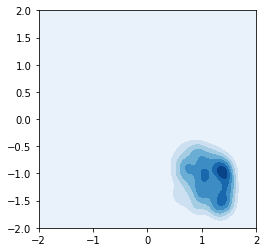

In [12]:
out2 = G(torch.FloatTensor(inputs).cuda()).detach().cpu().numpy()
kde(out2[:,0], out2[:,1], save_file='./expt_results/WMLPG_gp_aux1.png')#bbox=[-10,10,-10,10] )#

In [52]:
out2

array([[-0.86036456,  1.0392838 ],
       [-1.0700408 ,  0.9825464 ],
       [-0.99871624,  0.99911666],
       ...,
       [-1.077399  ,  0.83849835],
       [-1.1209743 ,  0.8505913 ],
       [-0.9395132 ,  1.0173827 ]], dtype=float32)